### Import the needed package

In [14]:
import sys
sys.path.insert(0, './../')

import os
import numpy as np
import pandas as pd
import utilities as utils

from random import randint
from dotenv import load_dotenv
load_dotenv()

True

### Global variables

In [2]:
path_full = os.environ.get("ORI_PATH")
path_dataset = os.path.join(path_full, "datasets", "splitted", "augmented", "test")
path_cdr_data = os.path.join(path_full, "data", "cdr_dataset.csv")

### Get the test mask images information

In [3]:
cdr_data = pd.read_csv(path_cdr_data)
cdr_data.head(5)

,id,label,eye_side,a_cdr,v_cdr,h_cdr
0,fff_0_111784_l_y_mask,0,l,0.340206,0.633803,0.560606
1,fff_0_111784_r_y_mask,0,r,0.300445,0.541667,0.538462
2,fff_0_113060_l_1_mask,0,l,0.473950,0.686275,0.670000
3,fff_0_113060_l_2_mask,0,l,0.516781,0.777778,0.680000
4,fff_0_113060_l_3_mask,0,l,0.491304,0.721154,0.697917


In [4]:
f_images = [img for img in os.listdir(path_dataset) if img.endswith(".jpg")]

test_img = pd.DataFrame(f_images, columns=["image"])
test_img["id"] = test_img["image"].apply(lambda x: x.split(".")[0])
test_img = test_img[['id', 'image']]
test_img["label"] = test_img["id"].apply(lambda x: x.split("_")[1])
test_img["eye_side"] = test_img["id"].apply(lambda x: x.split("_")[3])
test_img["image"] = test_img["image"].apply(lambda x: os.path.join(path_dataset, x))
test_img.rename(columns={"image": "path"}, inplace=True)

test_img.drop(columns=["path"]).head(5)

,id,label,eye_side
0,fff_0_115058_l_1_aug,0,l
1,fff_0_115058_r_3_aug,0,r
2,fff_0_121076_r_1_aug,0,r
3,fff_0_121362_l_1_aug,0,l
4,fff_0_121362_l_3_aug,0,l


In [5]:
model = utils.custom_load_model(os.path.join(path_full,
                                                "data",
                                                "model",
                                                "unet_model_aug.h5"))

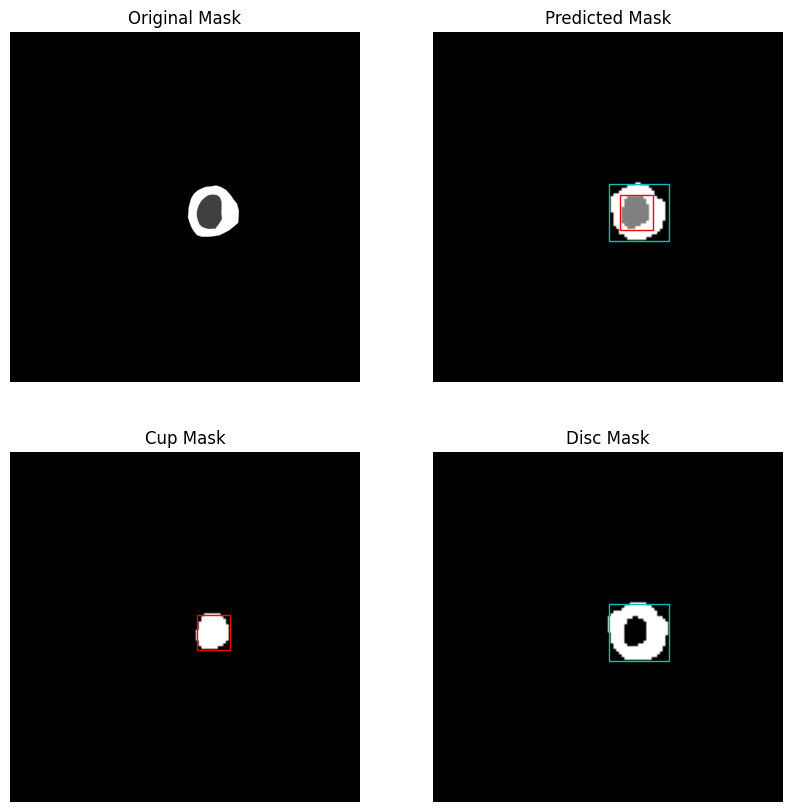

{'area_cdr': 0.3526170798898072, 'horizontal_cdr': 0.5454545454545454, 'vertical_cdr': 0.6190476190476191}


In [7]:
rand_idx = randint(0, len(test_img))
print(utils.ev_cdr(
    model=model,
    img_path=test_img.path[rand_idx],
    mask_path=os.path.join(path_dataset,
                            f"{test_img.id[rand_idx].replace('aug', 'mask')}.png"),
    threshold=.2,
    visualize=True
))

In [26]:
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

for i, row in test_img.iterrows():
    cdr_value = utils.ev_cdr(model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

ev_cdr.head(5)

,id,a_cdr,v_cdr,h_cdr
0,fff_0_115058_l_1_aug,0.277922,0.500000,0.500000
1,fff_0_115058_r_3_aug,0.300261,0.521739,0.590909
2,fff_0_121076_r_1_aug,0.191375,0.391304,0.476190
3,fff_0_121362_l_1_aug,0.372093,0.684211,0.555556
4,fff_0_121362_l_3_aug,0.407115,0.736842,0.611111


In [8]:
print(utils.count_loss_cdr(
                        cdr_data.drop(columns=["label", "eye_side"]),
                        ev_cdr))

{'a_mse': 0.01637964705675255, 'a_mae': 0.09855891147898738, 'a_huber': 0.008189824, 'h_mse': 0.07845843914869365, 'h_mae': 0.13376167283299756, 'h_huber': 0.036625426, 'v_mse': 0.218677080105335, 'v_mae': 0.17471202042190198, 'v_huber': 0.06615775}


In [ ]:
data = [0, {"a_huber":1.}]
for i in np.linspace(.1, .8, 8):
    threshold = round(i, 1)
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    print(f"Threshold: {threshold}")
    for idx, row in test_img.iterrows():
        cdr_value = utils.ev_cdr(model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    if loss["a_huber"] < data[1]["a_huber"]:
        data = [threshold, loss]

Threshold: 0.1


Threshold: 0.2
Threshold: 0.3
Threshold: 0.4
Threshold: 0.5


KeyboardInterrupt: 

In [25]:
data

[0, {'a_huber': 0.0}]